# Aplicação de Machine Learning para detecção de Fraude


Esse script tem por objetivo, a partir de uma base já tratada, avaliar o resultado de diferentes algoritmos de machine learning aplicados em uma base de operações de cartão de crédito.


-------------------------------------------------------------------------------

### Base de dados: Operações de Cartão de Crédito

kaggle.com/mlg-ulb/creditcardfraud

284,807 instâncias sem fraude
492 instâncias com fraude

30 atributos

2 classes (com frause, sem fraude)

--------------------------------------------------------------------------------
Trabalho de Conclusão de Curso apresentado ao Curso de Especialização em Inteligência Artificial e Aprendizado de Máquina como requisito parcial à obtenção do título de especialista.
Eloyza Maria S. B. Generozo


In [2]:
!pip install pydotplus
!pip install dtreeviz
!pip install imblearn
!pip install imbalanced-learn

In [1]:
import pandas as pd
import numpy as np
import pydotplus 
import matplotlib.pyplot as plt
import numpy as np

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import IsolationForest
from sklearn.neural_network import MLPClassifier
from sklearn import preprocessing
from sklearn.model_selection import StratifiedKFold


from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTE


In [3]:
creditcard = pd.read_csv('creditcard.csv') 

###### Normalizando campo Time ##############
creditcard['Time'] = preprocessing.MinMaxScaler().fit_transform(creditcard['Time'].values.reshape(-1, 1))

###### Removendo campos com baixa importancia e correlacao ##############
creditcard = creditcard.drop(['V1', 'V5', 'V21', 'V22', 'V23', 'V24', 'V28', 'Amount'], 1)
print(creditcard.head())

###### Removendo Outliers da Classe 0 ##############
iso_forest = IsolationForest(contamination=0.01, random_state=1)

# Separando por classe
target_0 = creditcard[creditcard.Class == 0]
target_1 = creditcard[creditcard.Class == 1]

# Prevendo outliers
iso_forest = iso_forest.fit(target_0)
sof_outliers = iso_forest.predict(target_0)

# Mantendo registros diferentes de outliers
target_0 = target_0[sof_outliers != -1]

# Concatenando novamente classe 0 filtrada com classe 1
creditcard = pd.concat([target_0, target_1], axis=0)


       Time        V2        V3        V4        V6        V7        V8  \
0  0.000000 -0.072781  2.536347  1.378155  0.462388  0.239599  0.098698   
1  0.000000  0.266151  0.166480  0.448154 -0.082361 -0.078803  0.085102   
2  0.000006 -1.340163  1.773209  0.379780  1.800499  0.791461  0.247676   
3  0.000006 -0.185226  1.792993 -0.863291  1.247203  0.237609  0.377436   
4  0.000012  0.877737  1.548718  0.403034  0.095921  0.592941 -0.270533   

         V9       V10       V11  ...       V15       V16       V17       V18  \
0  0.363787  0.090794 -0.551600  ...  1.468177 -0.470401  0.207971  0.025791   
1 -0.255425 -0.166974  1.612727  ...  0.635558  0.463917 -0.114805 -0.183361   
2 -1.514654  0.207643  0.624501  ...  2.345865 -2.890083  1.109969 -0.121359   
3 -1.387024 -0.054952 -0.226487  ... -0.631418 -1.059647 -0.684093  1.965775   
4  0.817739  0.753074 -0.822843  ...  0.175121 -0.451449 -0.237033 -0.038195   

        V19       V20       V25       V26       V27  Class  
0  0.40

In [4]:
###### Balanceado a base com SMOTE + TOMEK ##############
# Definindo PCA model para melhor perfomance tridimensional

pca = PCA(n_components=3)

def apply_smtetomek(X, y):
    
    X_3d = pca.fit_transform(X)
        
    # Definindo SMOTE para classe minoritária usando 5 vizinhos mais proximos
    sm = SMOTE(sampling_strategy='minority', k_neighbors=5) 
    # Passando smote definido no SMOTE + Tomek para retirar registros da classe majoritaria e aumentar da minoritaria
    smto = SMOTETomek(sampling_strategy='auto', smote=sm, random_state=1)
    X_smto, y_smto = smto.fit_sample(X_3d, y)

    return(X_smto, y_smto)


def obtemTreinoETesteBalanceado():
    ###### Separando variaveis classe dos demais ##############
    X = creditcard.iloc[:,0:(creditcard.shape[1] - 1)]
    le = LabelEncoder()
    y = le.fit_transform(creditcard.iloc[:,(creditcard.shape[1] - 1)]) 


    print("\nQuantidade de fraudes na base: {}".format(np.count_nonzero(y == 1)))
    print("Quantidade de normais na base: {}".format(np.count_nonzero(y == 0)))

    # Separando base de treino e teste
    X_train, X_test, y_train, y_test = train_test_split(
       X, 
       y, 
       test_size=0.3, 
       random_state=1)


    print("\nPercentual de fraudes base de teste: {}".format(np.count_nonzero(y_test == 1) / np.count_nonzero(y_test == 0)))
    print("Percentual de fraudes base de treino: {}".format(np.count_nonzero(y_train == 1) / np.count_nonzero(y_train == 0)))


    (X_train, y_train) = apply_smtetomek(X_train, y_train)
    (X_test, y_test) = apply_smtetomek(X_test, y_test)

    print("\nPercentual de fraudes sobre a base de teste: {}".format(np.count_nonzero(y_test == 1) / np.count_nonzero(y_test == 0)))
    print("Percentual de fraudes sobre a base de treino: {}".format(np.count_nonzero(y_train == 1) / np.count_nonzero(y_train == 0)))
    
    return(X_train, y_train, X_test, y_test)



In [5]:
def obtemMetricasCompleto(y_test, y_pred, nome_modelo):
    # Obtendo metricas
    print("\nAcurácia de previsão - "+ nome_modelo +":", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred, target_names=["Normal", "Fraude"]))

    # Matriz de Consufão
    cnf_matrix = confusion_matrix(y_test, y_pred)
    cnf_table = pd.DataFrame(data=cnf_matrix, index=["Normal", "Fraude"], columns=["Normal (prev)", "Fraude (prev)"])
    print(cnf_table)
    plt.matshow(cnf_matrix)
    plt.colorbar()
    plt.ylabel('Real Class')
    plt.xlabel('Predicted Class')
    plt.show()  
    
    # Curva AOC
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
    auc = metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr, color='blue',label='ROC (AUC = %0.4f)' % auc)
    plt.legend(loc='lower right')
    plt.title("ROC Curve " + nome_modelo)
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.show()
    
def obtemMetricasResumido(y_test, y_pred, nome_modelo):
    # Obtendo metricas
    print("\nAcurácia de previsão - "+ nome_modelo +":", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred, target_names=["Normal", "Fraude"]))

    # Matriz de Consufão
    cnf_matrix = confusion_matrix(y_test, y_pred)
    cnf_table = pd.DataFrame(data=cnf_matrix, index=["Normal", "Fraude"], columns=["Normal (prev)", "Fraude (prev)"])
    print(cnf_table)
    

### Decision Tree Classifier


Uma árvore de decisão é uma representação simples para classificar exemplos. É um aprendizado de máquina supervisionado onde os dados são continuamente di-vididos de acordo com um determinado parâmetro.A Árvore de Decisão consiste em Nodes, que testam o valor de um determinado atributo; Edges/Branch, que cor-respondem ao resultado de um teste e se conectam ao próximo nó ou folha; E os Leaf Nodes, nós terminais que prevêem o resultado (representam rótulos de classe ou distribuição de classe).


Quantidade de fraudes na base: 492
Quantidade de normais na base: 281471

Percentual de fraudes base de teste: 0.0017527030707831504
Percentual de fraudes base de treino: 0.0017459270161904279

Percentual de fraudes sobre a base de teste: 1.0
Percentual de fraudes sobre a base de treino: 1.0

Acurácia de previsão - Decision Tree: 0.8789757987135293
              precision    recall  f1-score   support

      Normal       0.82      0.98      0.89     84417
      Fraude       0.97      0.78      0.87     84417

    accuracy                           0.88    168834
   macro avg       0.89      0.88      0.88    168834
weighted avg       0.89      0.88      0.88    168834

        Normal (prev)  Fraude (prev)
Normal          82546           1871
Fraude          18562          65855


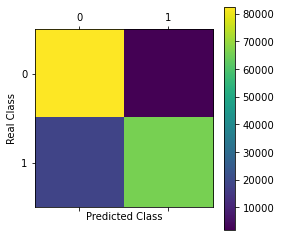

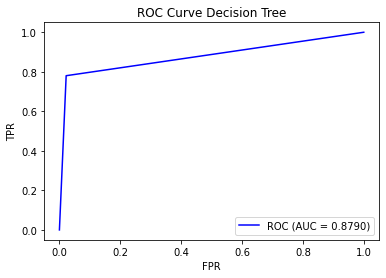

In [6]:
###### Executando DecisionTreeClassifier e avaliando resultado ##############

(X_train, y_train, X_test, y_test) = obtemTreinoETesteBalanceado()
model = DecisionTreeClassifier(min_samples_leaf=10, min_samples_split=10, random_state=1)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
obtemMetricasCompleto(y_test, y_pred, 'Decision Tree')

In [7]:
###### Executando DecisionTreeClassifier com Cross Validation e avaliando resultado ##############


###### Separando variaveis classe dos demais ##############
X = creditcard.iloc[:,0:(creditcard.shape[1] - 1)]
y = creditcard.iloc[:,(creditcard.shape[1] - 1)] 


kfold = StratifiedKFold(shuffle=True, random_state=1, n_splits=5)
for train_index, test_index in kfold.split(X, y):
    

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
        
    print("\nQuantidade de fraudes na base de treino: {}".format(np.count_nonzero(y_train == 1)/np.count_nonzero(y_train == 0)))
    print("Quantidade de fraudes na base de teste: {}\n".format(np.count_nonzero(y_test == 1)/np.count_nonzero(y_test == 0)))

    
    (X_train, y_train) = apply_smtetomek(X_train, y_train)
    (X_test, y_test) = apply_smtetomek(X_test, y_test)

    model = DecisionTreeClassifier(min_samples_leaf=10, min_samples_split=10, random_state=1)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    obtemMetricasResumido(y_test, y_pred, 'Decision Tree')




Quantidade de fraudes na base de treino: 0.0017497424237041248
Quantidade de fraudes na base de teste: 0.001740829558575362


Acurácia de previsão - Decision Tree: 0.7831982654439468
              precision    recall  f1-score   support

      Normal       0.71      0.96      0.82     56268
      Fraude       0.94      0.60      0.74     56268

    accuracy                           0.78    112536
   macro avg       0.82      0.78      0.78    112536
weighted avg       0.82      0.78      0.78    112536

        Normal (prev)  Fraude (prev)
Normal          54135           2133
Fraude          22265          34003

Quantidade de fraudes na base de treino: 0.0017452937022875339
Quantidade de fraudes na base de teste: 0.0017586243649412015


Acurácia de previsão - Decision Tree: 0.8640813788201848
              precision    recall  f1-score   support

      Normal       0.80      0.97      0.88     56280
      Fraude       0.97      0.75      0.85     56280

    accuracy                 

###  GaussianNB

Naive Bayes é uma técnica de classificação estatística baseada no Teorema de Ba-yes. É um dos algoritmos de aprendizagem supervisionada mais simples. O classifi-cador Naive Bayes é o algoritmo rápido, preciso e confiável. Os classificadores Naive Bayes têm alta precisão e velocidade em grandes conjuntos de dados.


Quantidade de fraudes na base: 492
Quantidade de normais na base: 281471

Percentual de fraudes base de teste: 0.0017527030707831504
Percentual de fraudes base de treino: 0.0017459270161904279

Percentual de fraudes sobre a base de teste: 1.0
Percentual de fraudes sobre a base de treino: 1.0

Acurácia de previsão - Naive Bayes: 0.88429052052977
              precision    recall  f1-score   support

      Normal       0.83      0.96      0.89     84414
      Fraude       0.95      0.81      0.87     84414

    accuracy                           0.88    168828
   macro avg       0.89      0.88      0.88    168828
weighted avg       0.89      0.88      0.88    168828

        Normal (prev)  Fraude (prev)
Normal          81105           3309
Fraude          16226          68188


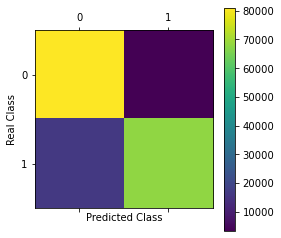

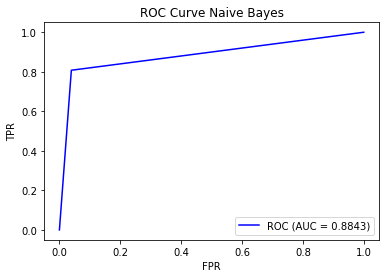

In [21]:
###### Executando Naive Bayes e avaliando resultado ##############
(X_train, y_train, X_test, y_test) = obtemTreinoETesteBalanceado()

model = GaussianNB()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

obtemMetricasCompleto(y_test, y_pred, 'Naive Bayes')



In [8]:
###### Executando Naive Bayes com Cross Validation e avaliando resultado ##############


###### Separando variaveis classe dos demais ##############
X = creditcard.iloc[:,0:(creditcard.shape[1] - 1)]
y = creditcard.iloc[:,(creditcard.shape[1] - 1)] 


kfold = StratifiedKFold(shuffle=True, random_state=1, n_splits=5)
for train_index, test_index in kfold.split(X, y):
    

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
        
    print("\nQuantidade de fraudes na base de treino: {}".format(np.count_nonzero(y_train == 1)/np.count_nonzero(y_train == 0)))
    print("Quantidade de fraudes na base de teste: {}\n".format(np.count_nonzero(y_test == 1)/np.count_nonzero(y_test == 0)))

    
    (X_train, y_train) = apply_smtetomek(X_train, y_train)
    (X_test, y_test) = apply_smtetomek(X_test, y_test)

    model = GaussianNB()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    obtemMetricasResumido(y_test, y_pred, 'Naive Bayes')




Quantidade de fraudes na base de treino: 0.0017497424237041248
Quantidade de fraudes na base de teste: 0.001740829558575362


Acurácia de previsão - Naive Bayes: 0.8237677245104659
              precision    recall  f1-score   support

      Normal       0.75      0.97      0.85     56278
      Fraude       0.96      0.68      0.79     56278

    accuracy                           0.82    112556
   macro avg       0.85      0.82      0.82    112556
weighted avg       0.85      0.82      0.82    112556

        Normal (prev)  Fraude (prev)
Normal          54625           1653
Fraude          18183          38095

Quantidade de fraudes na base de treino: 0.0017452937022875339
Quantidade de fraudes na base de teste: 0.0017586243649412015


Acurácia de previsão - Naive Bayes: 0.8941836081887973
              precision    recall  f1-score   support

      Normal       0.85      0.96      0.90     56272
      Fraude       0.95      0.83      0.89     56272

    accuracy                     

### Random Forest

Algoritmo que cria um conjunto de árvores de decisão a partir de um subconjunto do conjunto de treinamento selecionado aleatoriamente. Em se-guida, agrega os votos de diferentes árvores de decisão para decidir a classe final do objeto de teste.


Quantidade de fraudes na base: 492
Quantidade de normais na base: 281471

Percentual de fraudes base de teste: 0.0017527030707831504
Percentual de fraudes base de treino: 0.0017459270161904279

Percentual de fraudes sobre a base de teste: 1.0
Percentual de fraudes sobre a base de treino: 1.0

Acurácia de previsão - Random Forest Classifier: 0.8875884046296186
              precision    recall  f1-score   support

      Normal       0.82      0.99      0.90     84413
      Fraude       0.99      0.78      0.87     84413

    accuracy                           0.89    168826
   macro avg       0.90      0.89      0.89    168826
weighted avg       0.90      0.89      0.89    168826

        Normal (prev)  Fraude (prev)
Normal          83597            816
Fraude          18162          66251


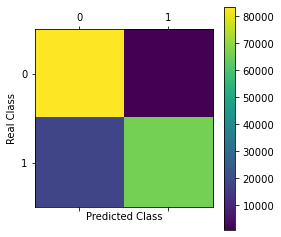

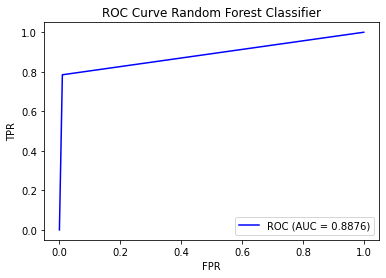

In [24]:
###### Executando RandomForestClassifier e avaliando resultado ##############
(X_train, y_train, X_test, y_test) = obtemTreinoETesteBalanceado()


model = RandomForestClassifier(n_estimators=100, n_jobs=4, random_state=1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

obtemMetricasCompleto(y_test, y_pred, 'Random Forest Classifier')



In [28]:
###### Executando Random Forest com Cross Validation e avaliando resultado ##############


###### Separando variaveis classe dos demais ##############
X = creditcard.iloc[:,0:(creditcard.shape[1] - 1)]
y = creditcard.iloc[:,(creditcard.shape[1] - 1)] 


kfold = StratifiedKFold(shuffle=True, random_state=1, n_splits=5)
for train_index, test_index in kfold.split(X, y):
    

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
        
    print("\nQuantidade de fraudes na base de treino: {}".format(np.count_nonzero(y_train == 1)/np.count_nonzero(y_train == 0)))
    print("Quantidade de fraudes na base de teste: {}\n".format(np.count_nonzero(y_test == 1)/np.count_nonzero(y_test == 0)))

    
    (X_train, y_train) = apply_smtetomek(X_train, y_train)
    (X_test, y_test) = apply_smtetomek(X_test, y_test)

    model = RandomForestClassifier(n_estimators=100, n_jobs=4, random_state=1)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    obtemMetricasResumido(y_test, y_pred, 'Random Forest Classifier')




Quantidade de fraudes na base de treino: 0.0017497424237041248
Quantidade de fraudes na base de teste: 0.001740829558575362


Acurácia de previsão - Random Forest Classifier: 0.5182855315065572
              precision    recall  f1-score   support

      Normal       0.51      0.98      0.67     56274
      Fraude       0.74      0.06      0.10     56274

    accuracy                           0.52    112548
   macro avg       0.63      0.52      0.39    112548
weighted avg       0.63      0.52      0.39    112548

        Normal (prev)  Fraude (prev)
Normal          55185           1089
Fraude          53127           3147

Quantidade de fraudes na base de treino: 0.0017452937022875339
Quantidade de fraudes na base de teste: 0.0017586243649412015


Acurácia de previsão - Random Forest Classifier: 0.8769992180835939
              precision    recall  f1-score   support

      Normal       0.81      0.99      0.89     56272
      Fraude       0.98      0.77      0.86     56272

    acc

### Multilayer Perceptron (MLP)

Rede neural com uma ou mais camadas ocultas com um número indeterminado de neurônios. A camada oculta possui esse nome porque não é possível prever a saída desejada nas camadas intermediárias. Para treinar a rede MLP, o algoritmo comu-mente utilizado é o de retropropagação (Backpropagation). Neste caso, como solver está sendo utilizado o adam, que conforme própria documentação do scikit-learn é indicado para bases grandes como é aqui o caso. O modelo terá duas camadas, com 32 neurônios na primeira e 16 na segunda. Já a função de ativação, será feito um comparativo entre a linear (identity) e sigmoidal (logistic e tanh), a função relu não será utilizada devido a característica da base com valores negativos.


Quantidade de fraudes na base: 492
Quantidade de normais na base: 281471

Percentual de fraudes base de teste: 0.0017527030707831504
Percentual de fraudes base de treino: 0.0017459270161904279

Percentual de fraudes sobre a base de teste: 1.0
Percentual de fraudes sobre a base de treino: 1.0

Resultados para: identity
Camadas da rede: 4
Neurônios na camada oculta: [32, 16]
Neurônios na camada de saída: 1
Pesos na camada de entrada: (3, 32)
Pesos na camada oculta: (32, 16)
Acurácia da base de treinamento: 0.91
Acurácia da base de teste: 0.94

Acurácia de previsão - Multi-layer Perceptron classifier: 0.9355075640008056
              precision    recall  f1-score   support

      Normal       0.93      0.94      0.94     84413
      Fraude       0.94      0.93      0.94     84413

    accuracy                           0.94    168826
   macro avg       0.94      0.94      0.94    168826
weighted avg       0.94      0.94      0.94    168826

        Normal (prev)  Fraude (prev)
Normal    

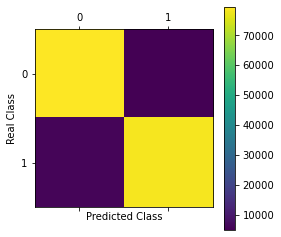

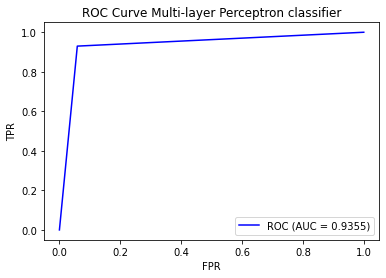

C:\Users\eloyz\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(



Resultados para: logistic
Camadas da rede: 4
Neurônios na camada oculta: [32, 16]
Neurônios na camada de saída: 1
Pesos na camada de entrada: (3, 32)
Pesos na camada oculta: (32, 16)
Acurácia da base de treinamento: 0.94
Acurácia da base de teste: 0.92

Acurácia de previsão - Multi-layer Perceptron classifier: 0.923897977799628
              precision    recall  f1-score   support

      Normal       0.90      0.96      0.93     84413
      Fraude       0.96      0.89      0.92     84413

    accuracy                           0.92    168826
   macro avg       0.93      0.92      0.92    168826
weighted avg       0.93      0.92      0.92    168826

        Normal (prev)  Fraude (prev)
Normal          80940           3473
Fraude           9375          75038


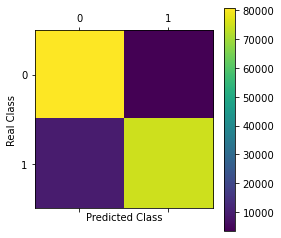

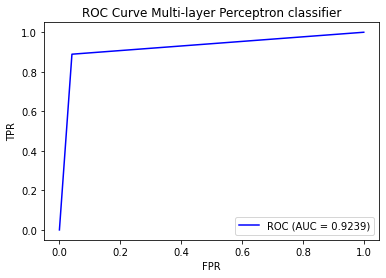

C:\Users\eloyz\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(



Resultados para: tanh
Camadas da rede: 4
Neurônios na camada oculta: [32, 16]
Neurônios na camada de saída: 1
Pesos na camada de entrada: (3, 32)
Pesos na camada oculta: (32, 16)
Acurácia da base de treinamento: 0.96
Acurácia da base de teste: 0.92

Acurácia de previsão - Multi-layer Perceptron classifier: 0.9200063971189272
              precision    recall  f1-score   support

      Normal       0.88      0.97      0.92     84413
      Fraude       0.97      0.87      0.92     84413

    accuracy                           0.92    168826
   macro avg       0.92      0.92      0.92    168826
weighted avg       0.92      0.92      0.92    168826

        Normal (prev)  Fraude (prev)
Normal          81788           2625
Fraude          10880          73533


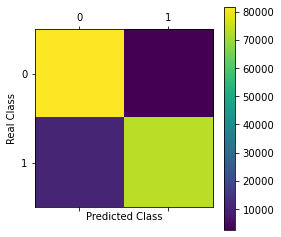

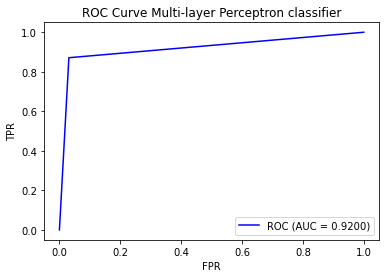

In [9]:
###### Executando MLPClassifier e avaliando resultado ##############

(X_train, y_train, X_test, y_test) = obtemTreinoETesteBalanceado()


def runMLP(neuronios_1, neuronios_2, activation_mode):
    mlp = MLPClassifier(activation=activation_mode, solver='adam', hidden_layer_sizes=[neuronios_1, neuronios_2], 
                        max_iter = 50, random_state=1)
    mlp.fit(X_train, y_train)
    y_pred = mlp.predict(X_test)

    print("\nResultados para: " + activation_mode)
    print("Camadas da rede: {}".format(mlp.n_layers_))
    print("Neurônios na camada oculta: {}".format(mlp.hidden_layer_sizes))
    print("Neurônios na camada de saída: {}".format(mlp.n_outputs_))
    print("Pesos na camada de entrada: {}".format(mlp.coefs_[0].shape))
    print("Pesos na camada oculta: {}".format(mlp.coefs_[1].shape))

    print("Acurácia da base de treinamento: {:.2f}".format(mlp.score(X_train, y_train)))
    print("Acurácia da base de teste: {:.2f}".format(mlp.score(X_test, y_test)))

    obtemMetricasCompleto(y_test, y_pred, 'Multi-layer Perceptron classifier')

    
runMLP(32, 16, 'identity')
runMLP(32, 16, 'logistic')
runMLP(32, 16, 'tanh')




In [32]:
###### Executando MLP com Cross Validation e avaliando resultado ##############


###### Separando variaveis classe dos demais ##############
X = creditcard.iloc[:,0:(creditcard.shape[1] - 1)]
y = creditcard.iloc[:,(creditcard.shape[1] - 1)] 


kfold = StratifiedKFold(shuffle=True, random_state=1, n_splits=5)
for train_index, test_index in kfold.split(X, y):
    

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
        
    print("\nQuantidade de fraudes na base de treino: {}".format(np.count_nonzero(y_train == 1)/np.count_nonzero(y_train == 0)))
    print("Quantidade de fraudes na base de teste: {}\n".format(np.count_nonzero(y_test == 1)/np.count_nonzero(y_test == 0)))

    
    (X_train, y_train) = apply_smtetomek(X_train, y_train)
    (X_test, y_test) = apply_smtetomek(X_test, y_test)

    model = MLPClassifier(activation='identity', solver='adam', hidden_layer_sizes=[32,16], 
                        max_iter = 50, random_state=1)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    obtemMetricasResumido(y_test, y_pred, 'MLP Identity')




Quantidade de fraudes na base de treino: 0.0017497424237041248
Quantidade de fraudes na base de teste: 0.001740829558575362


Acurácia de previsão - MLP Identity: 0.8265919067337255
              precision    recall  f1-score   support

      Normal       0.76      0.94      0.84     56269
      Fraude       0.93      0.71      0.80     56269

    accuracy                           0.83    112538
   macro avg       0.85      0.83      0.82    112538
weighted avg       0.85      0.83      0.82    112538

        Normal (prev)  Fraude (prev)
Normal          53115           3154
Fraude          16361          39908

Quantidade de fraudes na base de treino: 0.0017452937022875339
Quantidade de fraudes na base de teste: 0.0017586243649412015


Acurácia de previsão - MLP Identity: 0.9456714879704325
              precision    recall  f1-score   support

      Normal       0.94      0.95      0.95     56278
      Fraude       0.95      0.94      0.95     56278

    accuracy                   